In [1]:
import tensorflow as tf
keras = tf.keras
models = tf.keras.models
layers = tf.keras.layers 
import matplotlib.pyplot as plt
import os
os.environ['TF_KERAS'] = '0'


In [2]:
IMAGE_SIZE=256
BATCH_SIZE = 40
CHANNELS = 3
EPOCHS=50 

In [3]:
dataset = keras.preprocessing.image_dataset_from_directory(
    "color_image",
    shuffle=True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names= dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

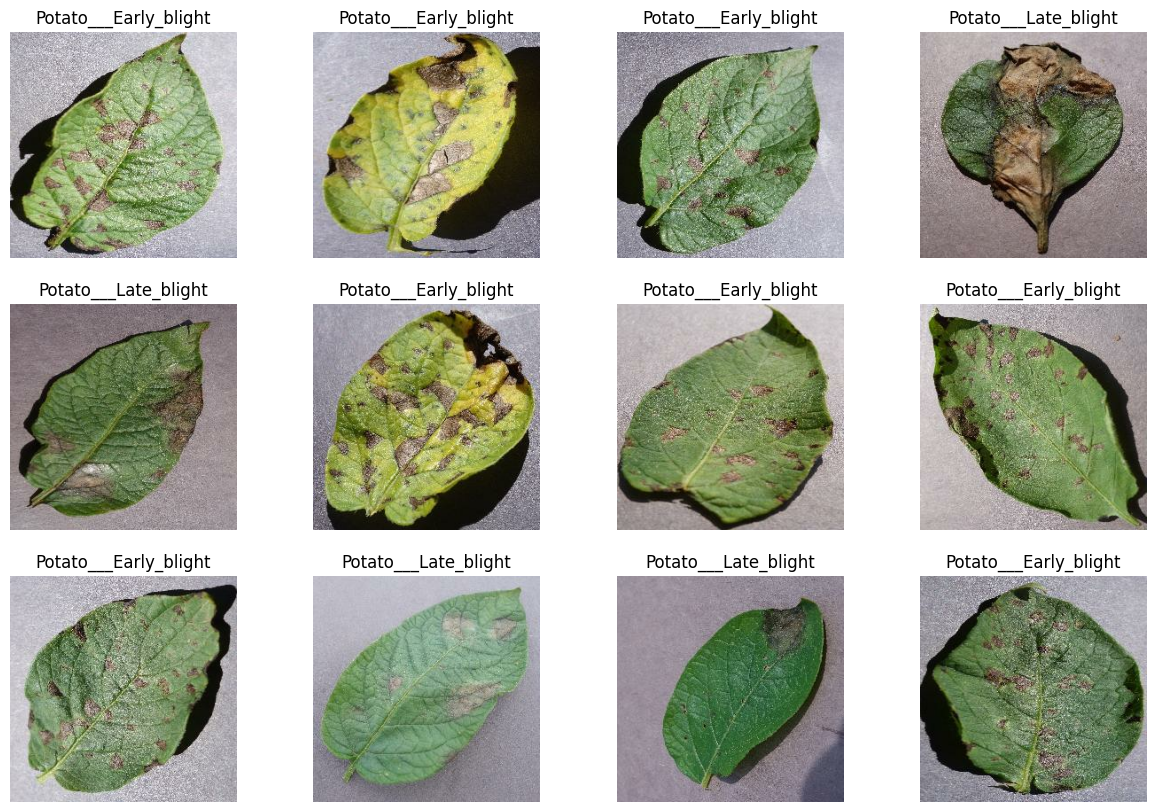

In [48]:
plt.figure(figsize=(15,10))
for image_batch, label_batch in dataset.take(1):
    for i in range (12):
        plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

    # 32 ảnh đầu tiên
    # print(label_batch.numpy())

In [6]:
# Iterations là số lượng batchs cần để hoàn thành 1 epoch.
len(dataset)  

54

In [7]:
# 80% ==> training
# 20% ==> 10% validation, 10% test

In [8]:
# train_size= 0.8
# len(dataset)*train_size

In [9]:
# train_ds = dataset.take(348)
# len(train_ds)

In [10]:
# test_ds=dataset.skip(348)
# len(test_ds)

In [11]:
# val_size = 0.1
# len(dataset)*val_size

In [12]:
# val_ds= test_ds.take(43)
# len(val_ds)

In [13]:
# test_ds = test_ds.skip(43)
# len(test_ds)

In [14]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size=len(ds)

    if shuffle:
        ds= ds.shuffle(shuffle_size, seed=12)
        
    train_size = int(train_split * ds_size)
    val_size = int(val_split*ds_size)
    train_ds = ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds

In [15]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000)


In [16]:
def process_label(image, label):
    return image, tf.clip_by_value(label, 0, 2)

train_ds = train_ds.map(process_label)
val_ds = val_ds.map(process_label)
test_ds = test_ds.map(process_label)

In [17]:
len(train_ds)


43

In [18]:
len(val_ds)


5

In [19]:

len(test_ds)

6

In [20]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size= tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size= tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size= tf.data.AUTOTUNE)

In [21]:
#đọc ảnh trên nhiều góc độ khác nhau giúp mô hình hđ chính xác hơn
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [22]:

data_augmentation = tf.keras.Sequential([
     layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),#lật ngang,dọc
     layers.experimental.preprocessing.RandomRotation(0.2),
])

In [57]:
input_shape = (BATCH_SIZE, IMAGE_SIZE,IMAGE_SIZE, CHANNELS)
n_classes = 3
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3), activation='relu',input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation ='softmax'),
])
model.build(input_shape=input_shape)

In [58]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (40, 254, 254, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (40, 127, 127, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (40, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (40, 62, 62, 64)          0         
 g2D)                                                 

In [25]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'])

In [26]:
history = model.fit(
    train_ds,
    epochs= EPOCHS,
    batch_size = BATCH_SIZE,
    verbose=1,
    validation_data = val_ds
)

Epoch 1/50


43/43 [==============================] - 119s 2s/step - loss: 0.9089 - accuracy: 0.4901 - val_loss: 0.9055 - val_accuracy: 0.4600
Epoch 2/50
43/43 [==============================] - 78s 2s/step - loss: 0.7999 - accuracy: 0.6308 - val_loss: 0.6542 - val_accuracy: 0.7400
Epoch 3/50
43/43 [==============================] - 84s 2s/step - loss: 0.4983 - accuracy: 0.8043 - val_loss: 0.4153 - val_accuracy: 0.7950
Epoch 4/50
43/43 [==============================] - 91s 2s/step - loss: 0.4120 - accuracy: 0.8300 - val_loss: 0.2591 - val_accuracy: 0.8850
Epoch 5/50
43/43 [==============================] - 96s 2s/step - loss: 0.3607 - accuracy: 0.8557 - val_loss: 0.2996 - val_accuracy: 0.8950
Epoch 6/50
43/43 [==============================] - 88s 2s/step - loss: 0.3188 - accuracy: 0.8721 - val_loss: 0.2901 - val_accuracy: 0.8800
Epoch 7/50
43/43 [==============================] - 87s 2s/step - loss: 0.3196 - accuracy: 0.8692 - val_loss: 0.3752 - val_accuracy: 0.8100
Epoch 8/50
43/43 

In [27]:
scores=model.evaluate(test_ds)

6/6 [==============================] - 9s 606ms/step - loss: 0.0300 - accuracy: 0.9917


In [28]:

scores

[0.030012276023626328, 0.9916666746139526]

In [29]:
history

In [30]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 43}

In [31]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [32]:
acc = history.history['accuracy']
val_acc=history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

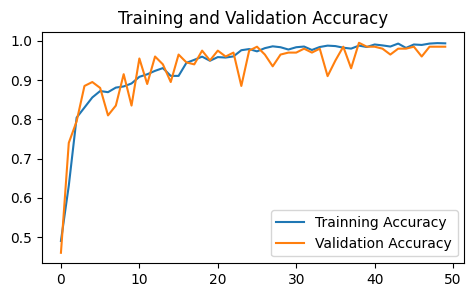

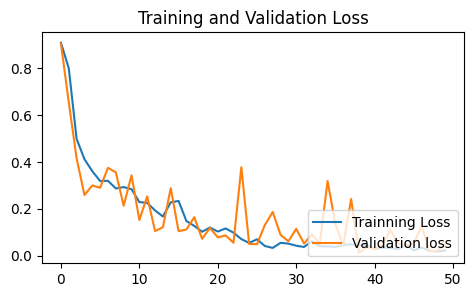

In [53]:
plt.figure(figsize =(12, 3)) 
plt.subplot(1,2,1) 
plt.plot(range(EPOCHS), acc, label='Trainning Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy') 

plt.figure(figsize =(12, 3)) 
plt.subplot(1,2,1) 
plt.plot(range(EPOCHS), loss, label='Trainning Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation loss')
plt.legend(loc='lower right')
plt.title('Training and Validation Loss') 

Ảnh dự đoán đầu tiên
Nhãn của ảnh đầu tiên: Potato___Early_blight
2/2 [==============================] - 2s 2s/step
Potato___Early_blight


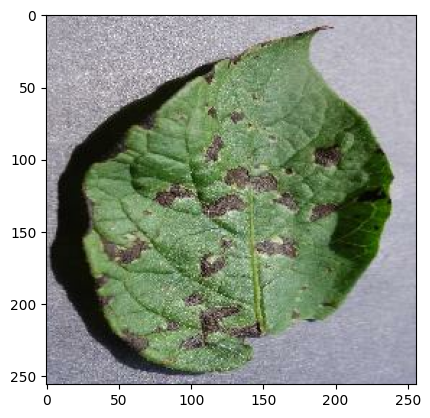

In [34]:
import numpy as np
for image_batch, label_batch in test_ds.take(1):

    first_image = image_batch[0].numpy().astype('uint8')
    first_lable = label_batch[0].numpy()
    print("Ảnh dự đoán đầu tiên")
    plt.imshow(first_image)
    print("Nhãn của ảnh đầu tiên:", class_names[first_lable])

    batch_prediction=model.predict(image_batch)
    print(class_names[np.argmax(batch_prediction[0])])

In [35]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array,0)  #tạo batch
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round( 100* (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 32ms/step


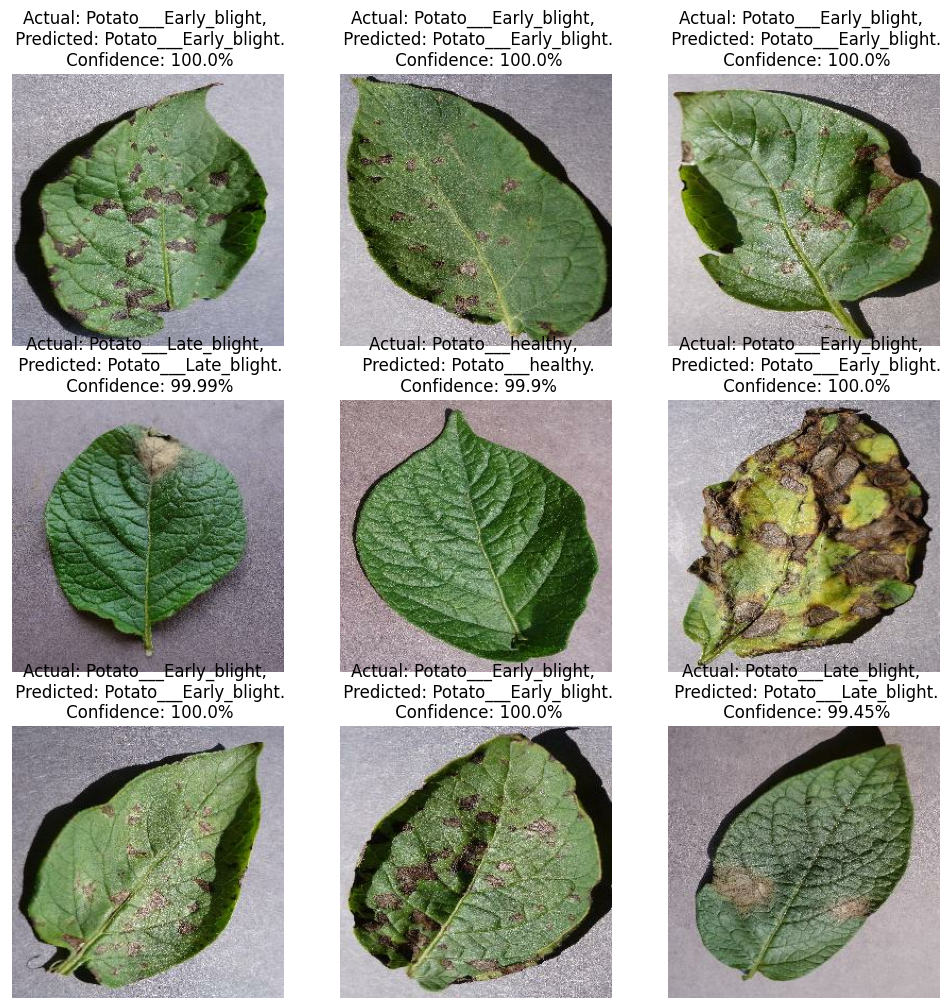

In [54]:
plt.figure(figsize =(12, 12))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))

        predicted_class, confidence = predict(model,images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

In [45]:
model_version = 4
model.save(r"C:\Users\DELL\Desktop\iot-bt\sketch_nov05a\model\4")



INFO:tensorflow:Assets written to: C:\Users\DELL\Desktop\iot-bt\sketch_nov05a\model\4\assets


INFO:tensorflow:Assets written to: C:\Users\DELL\Desktop\iot-bt\sketch_nov05a\model\4\assets
